In [1]:
import os
os.environ["HF_HUB_DISABLE_SSLVERIFICATION"] = "1"

In [2]:
import os
os.environ["TRANSFORMERS_VERIFIED_SSL"] = "false"

In [3]:
from decord import VideoReader, cpu
from PIL import Image
import numpy as np

In [4]:
def extract_video_frames(video_path, num_segments):
    vr = VideoReader(video_path, ctx=cpu(0))
    total = len(vr)
    idxs = np.linspace(0, total-1, num_segments, dtype=int)
    frames = [Image.fromarray(vr[idx].asnumpy()).convert('RGB') for idx in idxs]
    return frames

In [5]:
video_path = 'IMG_4049.mov'
frames = extract_video_frames(video_path, num_segments=8)

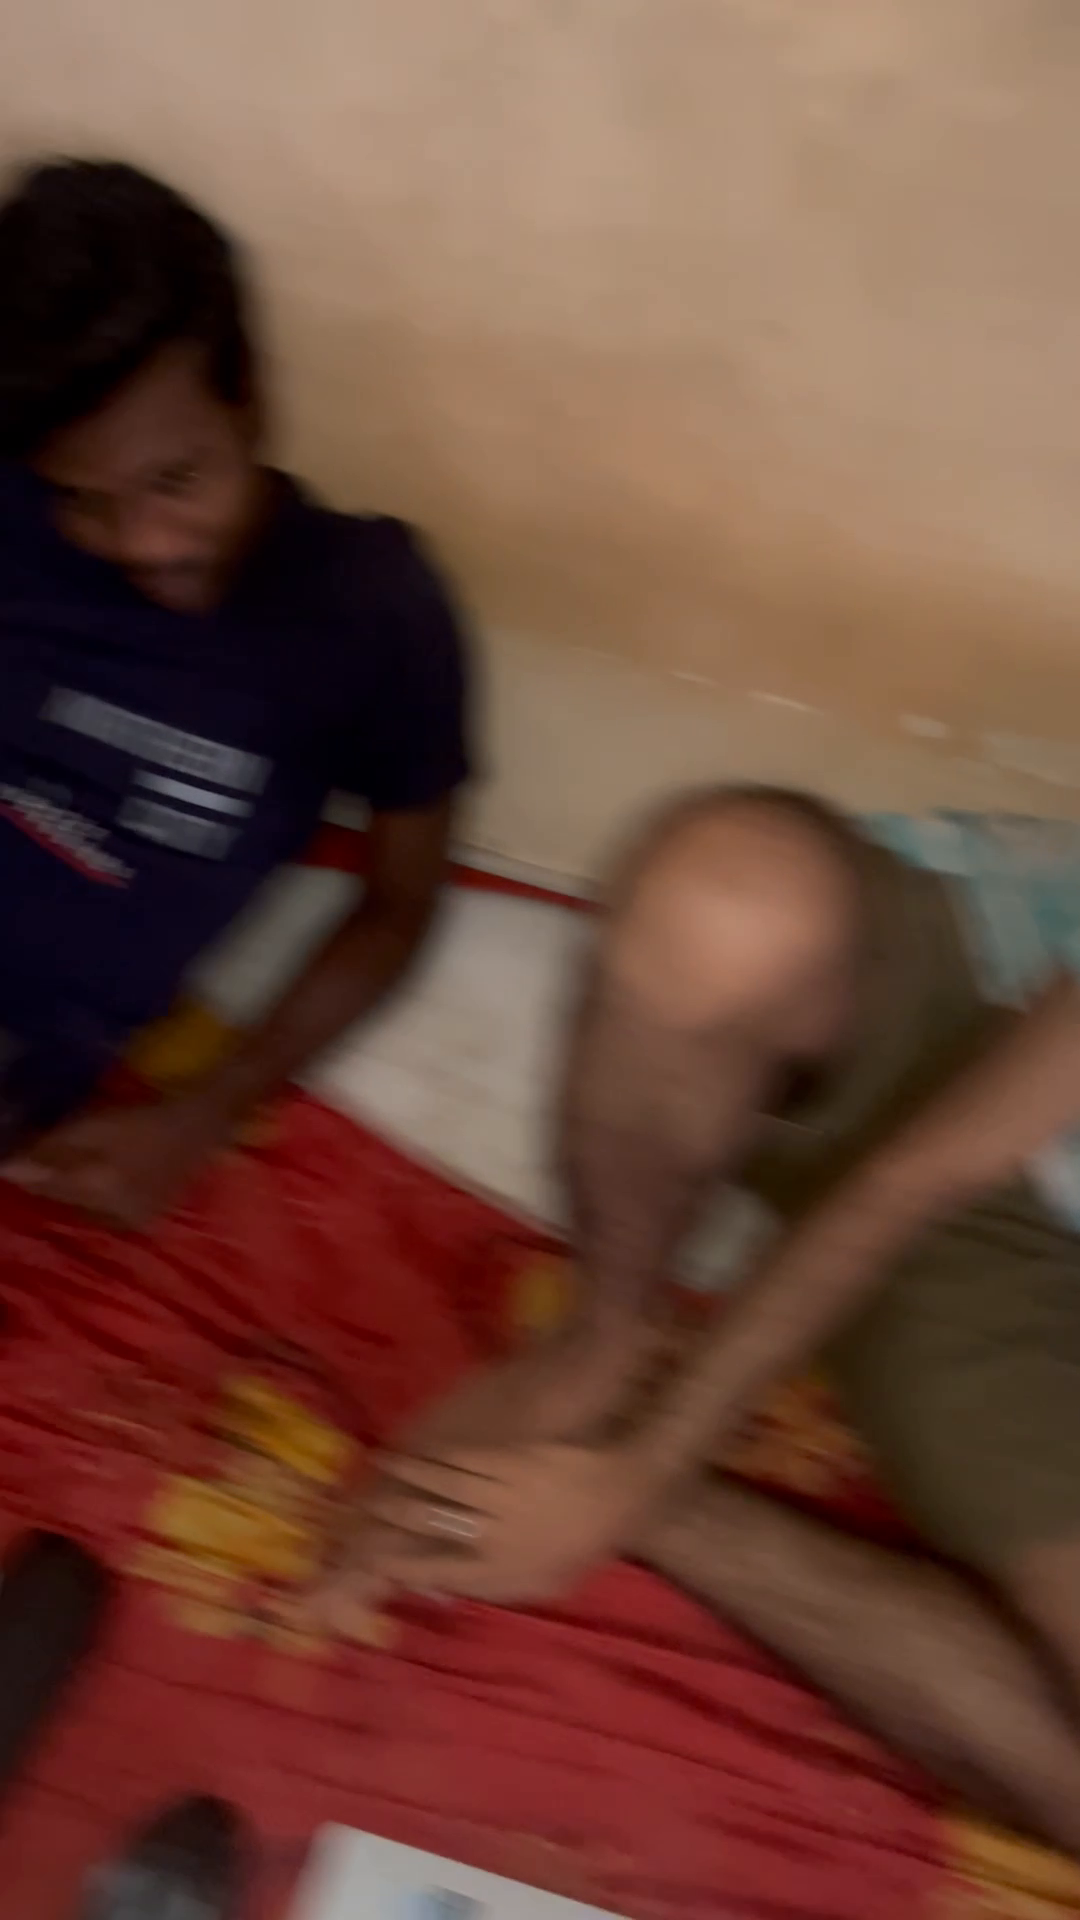

In [6]:
frames[1]

In [7]:
from transformers import AutoModelForVision2Seq, AutoProcessor
import torch

C:\Users\10839330\AppData\Roaming\Python\Python313\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
import requests
requests.get("https://huggingface.co").status_code

SSLError: HTTPSConnectionPool(host='huggingface.co', port=443): Max retries exceeded with url: / (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1018)')))

In [10]:
# from huggingface_hub import snapshot_download
# snapshot_download(repo_id=model_id)

In [ ]:
model_id = "Qwen/Qwen2.5-VL-7B-Instruct"
device = "cuda" if torch.cuda.is_available() else "cpu"

processor = AutoProcessor.from_pretrained(model_id)
model = AutoModelForVision2Seq.from_pretrained(model_id, torch_dtype = torch.float16 if device == 'cuda' else torch.float32).to(device)


In [ ]:
prompt = ("Summarize the important events in these video frames, nothing any traffic rule violations by vehicles and pedestrians, and indicate the approzimate frame number for each event.")

inputs = processor(images = frames, text = prompt, return_tensors = "pt").to(device)

In [ ]:
with torch.no_grad():
    output = model.generate(
        input_ids = inputs[input_ids],
        pixel_values = inputs["pixel_values"],
        max_new_tokens = 512,
        do_sample = False,

    )
    summary = processor.batch_decode(output, skip_special_tokens=True)[0]

    print(f"Summary : {summary}")